# Binary shapes in 2D
### Simulation written by Rachael Skye and Maya Martirossyan

In [1]:
!tar -xzf ./hoomd-v2.9.7.tar.gz
#!pip install pip-tools
#!pip-compile requirements.txt

In [22]:
# importing modules

import hoomd
import hoomd.hpmc as hpmc
import coxeter
import ipywidgets as widgets
import gsd, gsd.hoomd
import numpy as np
import matplotlib.pyplot as pp
import random
import rowan
import plato.draw.vispy as draw
#%gui qt

OSError: GL ES 2.0 library not found

### Setup Functions

Setting up some functions that we will use throughout our simulation code. These need to be evaluated, but do not need to be interacted with. 

In [72]:
# Functions for defining shapes

get_3D_Shape = coxeter.families.RegularNGonFamily()

def make3D(vertex_list):
    """
    input: vertex_list for 2D shapes
    output: vertex_list for same shapes but "in 3D"
    """
    to_add = np.transpose([np.zeros(len(vertex_list))])
    vertex_list = np.concatenate([vertex_list,to_add],axis=1)
    return vertex_list

def get_shape(vertex_count):
    return make3D(get_3D_Shape.make_vertices(vertex_count))

#the interactive display for selecting fraction of each shape
shape_ratio = widgets.FloatSlider(
    min=0.00, 
    max=1.00, 
    step=0.01, 
    description='Shape ratio (%A):', 
    value=0.50,
    readout_format='.2f')

#Colors of each shape
# setting colors
# RGB values between 0 and 1
color_A = np.float32(np.divide([255, 50, 150], 255)) #pink
color_B = np.float32(np.divide([0, 200, 100], 255)) #green

In [73]:
# Functions for initializing the simulation with HOOMD

def initialize(num_particles): 
    init = hoomd.init.create_lattice(unitcell=hoomd.lattice.unitcell(N=2,
                                                                  a1=[3,0,0],
                                                                  a2=[0,6,0],
                                                                  a3=[0,0,1],
                                                                  dimensions=2,
                                                                  position=[[0,0,0],
                                                                            [0,3,0]],
                                                                  type_name=["A","B"]),
                                n=[num_particles,int(1/2*num_particles)])
    return(init)
    
    
def set_shape_ratio(system, ratio):
    # taking snapshot of the first frame
    snap = system.take_snapshot()

    # defining particle types
    snap.particles.types = ["A","B"]

    nParticles = len(snap.particles.typeid)
    
    # first, assign all particles to be type B
    for p in range(nParticles):
        snap.particles.typeid[p] = 1
    
    # next, randomly assign certain particles to be type A
    partnum_A = int(nParticles*ratio.value)
    idlistA=[]
    for p in range(partnum_A):
        r = random.randint(0, nParticles - 1)
        while r in idlistA:
            r = random.randint(0, nParticles - 1)
        snap.particles.typeid[r] = 0
        idlistA.append(r)
        
    return snap

In [74]:
# Functions for visualizing our simulation

def draw_2D(snap, verticesA, verticesB):
    # primA and primB define our two groups of particles (A type and B type)
    primA = draw.Polygons(vertices = verticesA[:,:2])
    primB = draw.Polygons(vertices = verticesB[:,:2])

    # drawing the box
    box_prim = draw.Box(color=(0, 0, 0, 1), width=.2) 

    # drawing the scene with both primitives
    scene = draw.Scene([primA, box_prim], zoom=.5, clip_scale=5)
    scene.add_primitive(primB)
    scene.show()

    box = [snap.box.Lx, snap.box.Ly, snap.box.Lz, snap.box.xy, snap.box.xz, snap.box.yz]
    for (name, val) in zip(['Lx', 'Ly', 'Lz', 'xy', 'xz', 'yz'], box):
        setattr(box_prim, name, val)

    # reading in particle positions
    primA.positions = snap.particles.position[snap.particles.typeid == 0,:2]
    primB.positions = snap.particles.position[snap.particles.typeid == 1,:2]

    # reading in shape orientations
    primA.orientations = snap.particles.orientation
    primB.orientations = snap.particles.orientation

    # reading in shape sizes
    primA.diameters = np.full(len(snap.particles.position), 1)
    primB.diameters = np.full(len(snap.particles.position), 1)

    # colorsA = RGBA from 0 to 1
    colorsA = np.ones((len(primA.positions), 4))
    colorsA[:, :3] = color_A
    primA.colors = colorsA

    # colorsB = RGBA from 0 to 1
    colorsB = np.ones((len(primB.positions), 4))
    colorsB[:, :3] = color_B
    primB.colors = colorsB

    scene.render()
    
    
def getFrameCount(fname):
    """
    inputs: fname, the filename (ex: 'dump.gsd')
    outputs: len(traj), number of frames in simulation
    """
    with gsd.hoomd.open(fname, 'rb') as traj:
        return len(traj)

### Choosing parameters for our simulation

This includes choosing the two shapes we will be using, the ratio between the shapes, and the total number of shapes in the simulation box. Here, user input is important! 

As a scientist, you will want to also make a prediction (hypothesis) at this point. Think about how the simulation outcome might depend on your choice of shapes and their ratio. A good experiment also only changes one thing at a time -- decide which parameter you'd like to vary and which you'd like to keep constant.

In [82]:
# we will be using regular polygons for our shapes

# choose shapes by the number of vertices that shape has
# Example: verticesA = get_shape(3) will choose triangles for shapeA
verticesA = get_shape(3)
verticesB = get_shape(8)
verts=[verticesA, verticesB]

In [87]:
# choose a fraction between 0 and 1
# which will represent the percent of shapes that are shape A
# example:
# shape_ratio = 0 means all the shapes will be shape B

display(shape_ratio)

FloatSlider(value=0.15, description='Shape ratio (%A):', max=1.0, step=0.01)

In [88]:
# setting number of particles along one side of our simulation box
# which is the square root of the total number of particles

num_particles_sqrt = 20

### Initializing the simulation

Here, we will use the functions for simulation initialization written above, and execute them with the inputs given by the user. We can then visualize what we've initialized -- the first frame of the simulation.

In [89]:
hoomd.context.initialize("--mode=cpu");

# defining the first frame of our simulation
# set up lattice of particles
system = initialize(num_particles_sqrt)

#Set the system to have the correct shape ratio
system_with_shapes = set_shape_ratio(system, shape_ratio)
    
system.restore_snapshot(system_with_shapes)

notice(2): Group "all" created containing 400 particles


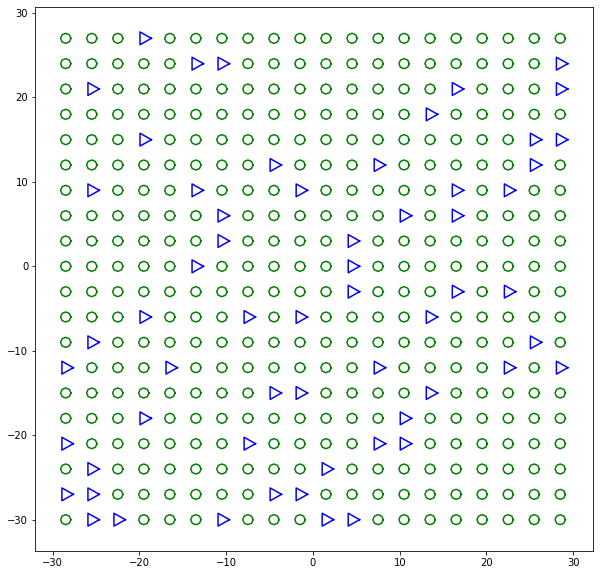

In [90]:
# visualizing our initial frame with plato

# initial_frame = system.take_snapshot()

# draw_2D(initial_frame, verticesA, verticesB)

colors=['b','g']
fig = pp.figure(figsize=(10,10))
for p in system.particles:
    pos = p.position
    unrotatedVerts = verts[p.typeid]
    completedShape = np.concatenate([unrotatedVerts,[unrotatedVerts[0]]])
    orientation = p.orientation
    rotatedVerts = rowan.rotate(orientation,completedShape)
    location= rotatedVerts + pos
    toPlot = np.transpose(location[:, 0:2])
    color = colors[p.typeid]
    
    pp.plot(toPlot[0],toPlot[1], c=color)

    

### Running the simulation

Now, we finally execute the simulation itself. This has a couple steps -- first, we set some basic parameters, such as timesteps, pressure, and how 'hard' we are shaking our simulation box (more technically, how large our steps/rotations are). In the next cell, we record the data in the form of a gsd file (with the simulation frames) and a log file (with some simulation parameters that help us see how volume and pressure are changing).

Note: If you have already run a simulation, make sure to update the filename that your new simulation will be saved to (in the second cell below).

In [91]:
# simulation setup

# pressure and time settings
total_steps = 2e5
max_pressure = 10

# Monte Carlo settings
mc = hpmc.integrate.convex_polygon(seed=np.random.randint(1,1e6), d=0.5, a=0.5, move_ratio=0.5)
mc.shape_param.set('A', vertices=verticesA)
mc.shape_param.set('B', vertices=verticesB)

boxMC = hpmc.update.boxmc(mc, hoomd.variant.linear_interp(points=[[0,1],[total_steps,max_pressure]],zero=0), 
                          np.random.randint(1,1e6))

boxMC.volume(delta=1.0, weight=1.0)

# define our simulation tuners
particle_tuner = hpmc.util.tune(obj=mc, tunables=['d','a'], target=0.2)
box_tuner = hpmc.util.tune_npt(obj=boxMC, tunables=['dV'],  target=0.2)

def update_tuner(particle_tuner, box_tuner):
    particle_tuner.update()
    box_tuner.update()


all=hoomd.group.all()

In [92]:
# record data

# for visualizations
traj = hoomd.dump.gsd(filename='traj.gsd',period=int(total_steps/100),group=all,overwrite=True)
traj.dump_shape(mc)

# for plots
logger = hoomd.analyze.log(filename='log.txt',
    quantities=['hpmc_translate_acceptance',
                'hpmc_rotate_acceptance',
                'hpmc_boxmc_volume_acceptance',
                'hpmc_d',
                'lx',
                'hpmc_boxmc_betaP',
                'hpmc_overlap_count'
                ],
    period=int(total_steps/100),
    overwrite=True)

In [93]:
# running simulation

# defining number of times we will tune the step size parameters
number_loops = 100
loop_steps = int(total_steps/number_loops)

hoomd.run(total_steps, 
          callback_period = loop_steps, 
          callback = lambda tuner: update_tuner(particle_tuner,box_tuner))

** starting run **
Time 00:00:16 | Step 8352 / 200000 | TPS 835.15 | ETA 00:03:49
Time 00:00:26 | Step 17048 / 200000 | TPS 869.543 | ETA 00:03:30
Time 00:00:36 | Step 25421 / 200000 | TPS 837.173 | ETA 00:03:28
Time 00:00:46 | Step 32032 / 200000 | TPS 661.093 | ETA 00:04:14
Time 00:00:56 | Step 38630 / 200000 | TPS 659.794 | ETA 00:04:04
Time 00:01:06 | Step 45091 / 200000 | TPS 645.996 | ETA 00:03:59
Time 00:01:16 | Step 51104 / 200000 | TPS 601.212 | ETA 00:04:07
Time 00:01:26 | Step 56521 / 200000 | TPS 541.605 | ETA 00:04:24
Time 00:01:36 | Step 62822 / 200000 | TPS 630.022 | ETA 00:03:37
Time 00:01:46 | Step 69416 / 200000 | TPS 659.386 | ETA 00:03:18
Time 00:01:56 | Step 75841 / 200000 | TPS 642.423 | ETA 00:03:13
Time 00:02:06 | Step 82414 / 200000 | TPS 657.243 | ETA 00:02:58
Time 00:02:16 | Step 88770 / 200000 | TPS 635.488 | ETA 00:02:55
Time 00:02:26 | Step 94600 / 200000 | TPS 582.942 | ETA 00:03:00
Time 00:02:36 | Step 100189 / 200000 | TPS 558.844 | ETA 00:02:58
Time 00

### Visualizing your simulation

Your simulation is now complete! It's time to see what the result was.

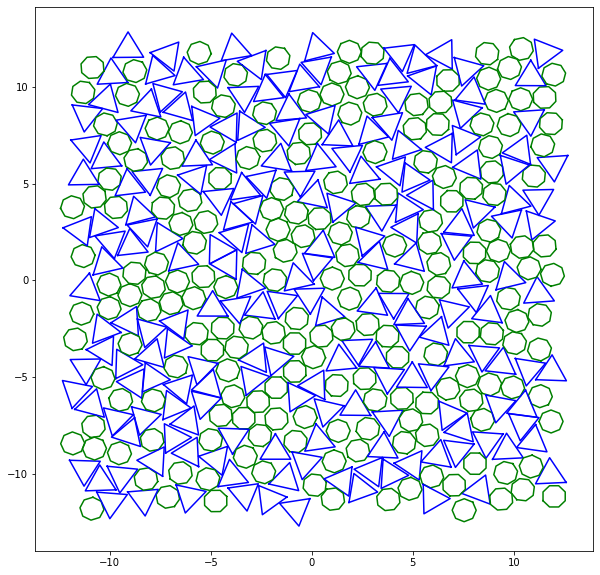

In [66]:
colors=['b','g']
fig = pp.figure(figsize=(10,10))
for p in system.particles:
    pos = p.position
    unrotatedVerts = verts[p.typeid]
    completedShape = np.concatenate([unrotatedVerts,[unrotatedVerts[0]]])
    orientation = p.orientation
    rotatedVerts = rowan.rotate(orientation,completedShape)
    location= rotatedVerts + pos
    toPlot = np.transpose(location[:, 0:2])
    color = colors[p.typeid]
    
    pp.plot(toPlot[0],toPlot[1], c=color)

In [68]:
filename = 'traj.gsd'
frame_num = getFrameCount(filename)

In [116]:
# visualizations
# looping over frames

@widgets.interact(frame_index=(0, frame_num-1, 1))
def plot(frame_index=0):
    with gsd.hoomd.open(filename, 'rb') as traj:
        pp.figure(figsize=(10,10))
        
        frame = traj[frame_index]
        box = frame.configuration.box

        for p in range(len(frame.particles.position)):
            pos = frame.particles.position[p]
            unrotatedVerts = verts[frame.particles.typeid[p]]
            completedShape = np.concatenate([unrotatedVerts,[unrotatedVerts[0]]])
            orientation = frame.particles.orientation[p]
            
            rotatedVerts = rowan.rotate(orientation,completedShape)
            location= rotatedVerts + pos
            toPlot = np.transpose(location[:, 0:2])
            color = colors[frame.particles.typeid[p]]

            pp.plot(toPlot[0],toPlot[1], c=color)
            

interactive(children=(IntSlider(value=0, description='frame_index', max=99), Output()), _dom_classes=('widget-…

### Plotting simulation data over time

In [ ]:
data = np.loadtxt('log.txt',skiprows=1)

In [ ]:
# Volume changes with time

time = data[:,0]
lx = data[:,5]
volume = lx ** 3

pp.scatter(time, volume);
pp.title('Volume change over timesteps');
pp.xlabel('Steps');
pp.ylabel('Volume');

In [ ]:
# Volume changes with pressure

pressure = data[:,6]
lx = data[:,5]
volume = lx ** 2

pp.scatter(pressure, volume);
pp.title('Volume change over pressure');
pp.xlabel('Pressure');
pp.ylabel('Volume');

In [ ]:
# Zoom in on the part below the initial compression

pp.scatter(pressure, volume);
pp.title('Volume change over pressure');
pp.xlabel('Pressure');
pp.ylabel('Volume');

pp.ylim(400,1000)